In [ ]:
# Deep Q Learning Algorithm Implementation

In [1]:
import torch
import random
import gym

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms
from collections import deque

from IPython.display import clear_output
%matplotlib inline

In [2]:
LEARNING_RATE = 0.0001
DISCOUNT = 0.99
EPISODES = 25000
SHOW_EVERY = 300
BATCH_SIZE = 4
rewards_path = 'rewards.npy'
STARTING_EPSILON = 0.9
END_EPSILON = 0.1
DECAY_RATE = 0.9999
BATCH_SIZE = 32

In [3]:
# One hidden layer function approximator
class Actor(nn.Module):

    def __init__(self, starting_epsilon, end_epsilon, decay_rate, batch_size):
        super(Actor, self).__init__()
        self. eps = starting_epsilon
        self.eps_end = end_epsilon
        self.eps_decay = decay_rate
        self.criterion = torch.nn.MSELoss()
        self.batch_size = batch_size       
        self.block = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, ip):
        return self.block(ip)
    
    
    def act(self, ip):
        self.eps = max(self.eps*self.eps_decay, self.eps_end)      # Decay Doubt Batch random acting doubt
        ip   = torch.FloatTensor(ip).unsqueeze(0)

        if random.random() < self.eps:
            return env.action_space.sample()
        else:
            return self.forward(ip).max(dim=1)[1].item()
        
    def update(self, memory, optimizer, loss):
        
        if len(memory) < self.batch_size:
            return 0 
        
        states, actions, rewards, next_states, dones = memory.sample(self.batch_size)
        
        states      = (torch.FloatTensor(np.float32(states)))
        next_states = (torch.FloatTensor(np.float32(next_states)))
        actions     = (torch.LongTensor(actions)).unsqueeze(1)
        rewards     = (torch.FloatTensor(rewards))
        dones       = (torch.FloatTensor(dones))

        q = self.forward(states).gather(1, actions).squeeze(1)
        q_expected = rewards + self.forward(next_states).max(dim=1)[0] * (1 - dones)
        
        td_loss = self.criterion(q, q_expected.detach())
        loss += td_loss.item()
        
        optimizer.zero_grad()
        td_loss.backward()
        optimizer.step()
        
        return loss
        
    
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Linear') != -1:
#         nn.init.normal_(m.weight, 0, 1)

In [4]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
# Instaciate action_value_function class
q_hat = Actor(STARTING_EPSILON, END_EPSILON, DECAY_RATE, BATCH_SIZE)
memory = ReplayBuffer(1000)

# q_hat_target = Actor()
# q_hat_target.load_state_dict(q_hat.state_dict())

env = gym.make("CartPole-v0")
cart_position, cart_velocity, angle, pole_tip_velocity = env.reset()
print('cart_position: %5.2f | cart_velocity: %5.2f | angle: %5.2f | Pole Tip velocity: %5.2f'%(cart_position, cart_velocity, angle, pole_tip_velocity))
# Test number of actions and other parameters

print('observation_space:',env.observation_space.low,'to',env.observation_space.high,'| Number of action values:',env.action_space.n)

cart_position:  0.03 | cart_velocity:  0.02 | angle:  0.02 | Pole Tip velocity: -0.04
observation_space: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] to [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38] | Number of action values: 2


In [6]:
optimizer = optim.RMSprop(q_hat.parameters(), lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [7]:
def plot(episode, avg_loss, eps, eps_rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episode: %5d | Average Loss: %5.2f | Epsilon: %4.2f | Avg. Reward: %5.2f'%(episode, np.mean(ep_loss[-20:]), eps, np.mean(ep_rewards[-20:])))
    plt.plot(eps_rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(ep_loss)
    plt.show()

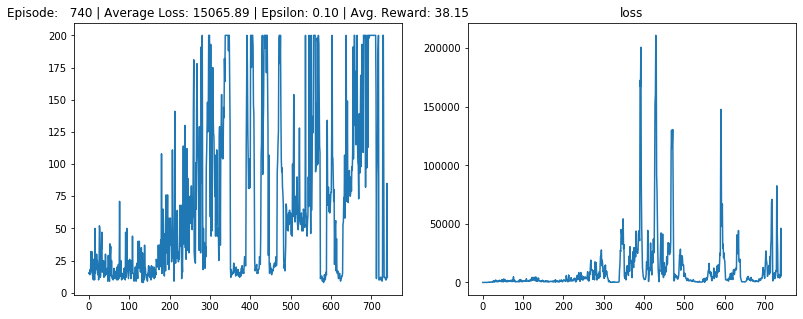

KeyboardInterrupt: 

In [8]:
avg_loss = 0
STEPS = 200
ep_rewards = np.array([])
ep_loss = np.array([])

# Train agent
for episode in range(EPISODES):
    # Episode wise inits
    state = env.reset()
    ep_reward = 0
    running_loss = 0
    done = 0
    
    # Collect Trajectory
    while not done:
        
        action = q_hat.act(state)
        next_state, reward, done, _ = env.step(action)

        ep_reward += reward
        memory.push(state, action, reward, next_state, done)
       
        state = next_state
    
        #Update
        running_loss = q_hat.update(memory, optimizer, running_loss)
    
    ep_rewards = np.append(ep_rewards, ep_reward)
    ep_loss = np.append(ep_loss, running_loss)

    if episode%20 == 0:
        plot(episode, ep_loss, q_hat.eps, ep_rewards)
        avg_loss = 0
        ep_reward = 0
        np.save(rewards_path, ep_rewards)

env.close()

In [ ]:
avg_loss = 0
STEPS = 200
ep_rewards = np.array([])

# Train agent
for episode in range(EPISODES):
    state = env.reset()
    state = torch.from_numpy(state).float()
    done = False
    ep_reward = 0
    
    if episode%SHOW_EVERY == 0:
        print('#'*30,'| RENDERING |','#'*30)
        RENDER = True
    else:
        RENDER = False

    running_loss = 0
    cont = 0

    while not done:
#         if RENDER:
#             env.render()
        
        q = q_hat(state)
        
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q).item()
        
        next_state, reward, done, _ = env.step(action)
        next_state = torch.from_numpy(next_state).float()
        ep_reward += reward
        
        q_estim = q[action]
#         q_target = q.clone()
    
        q_target = torch.tensor(reward) + (DISCOUNT * torch.max(q_hat(next_state)) * (not done))
        
#         print(q, q_target.detach(), torch.max(q_hat(next_state)))
        loss = criterion(q_estim, q_target.detach())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        running_loss += loss.item()
        
#     q_hat_target.load_state_dict(q_hat.state_dict())
        
    epsilon *= .9995
#     scheduler.step()
    ep_rewards = np.append(ep_rewards, ep_reward)

    avg_loss += running_loss
#     env.close()
    if episode%100 == 0:
        print('Episode: %5d | Average Loss: %5.2f | Epsilon: %4.2f | Avg. Reward: %5.2f'%(episode, avg_loss/100, epsilon, np.mean(ep_rewards[-100:])))
        avg_loss = 0
        ep_reward = 0
        np.save(rewards_path, ep_rewards)

env.close()

In [ ]:
# Save model
torch.save(q_hat.state_dict(),'./models/cartpole-v0.pth')

In [ ]:
# Test your policy
env.close()
state = torch.from_numpy(env.reset()).float()
done = False
EPS_TEST = 0.05

for step in range(200):
    env.render()
    q = q_hat((state))
    action = torch.argmax(q).item()
#     if random.random() < EPS_TEST:
#         action = env.action_space.sample() 
    next_state, reward, done, _ = env.step(action)
    
    next_state = torch.from_numpy(next_state).float()
    state = next_state
#     if reward == 1:
#         print('Hell Yes!')
        
    
env.close()

In [ ]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F


In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
USE_CUDA = False#torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


In [ ]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)


In [ ]:
env_id = "CartPole-v0"
env = gym.make(env_id)


In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
action_value_function

In [ ]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])


In [ ]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action


In [ ]:
model = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.001)

replay_buffer = ReplayBuffer(1000)


In [ ]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss


In [ ]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [ ]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)


In [ ]:
import torch
import random 

ind = torch.ones(10,1).long()
for i in range(10):
    ind[i] = random.randrange(0, 3)
print(ind)

In [ ]:

a = torch.ones((10,3))
for i in range(10):
    a[i,0] = i
    a[i,1] = i*i
    a[i,2] = i*i*i

In [ ]:
a.max(dim=1)

In [ ]:
a.gather(1, ind)

In [ ]:
a.shape